In [1]:
#Importing important packages

In [2]:
import pandas as pd
import re,string
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
df = pd.read_csv("sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Data cleaning and analysis

In [4]:
#Dropping id, reviews_date since id is related to product name and we dont need reviews_date for analysis

In [5]:
df.drop(['id','reviews_date'],axis=1,inplace=True)

Data Pre-Processing

In [6]:
df.shape

(30000, 13)

In [7]:
df.dtypes

brand                   object
categories              object
manufacturer            object
name                    object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating           int64
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

In [8]:
df.isnull().sum()

brand                       0
categories                  0
manufacturer              141
name                        0
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

Since we shall be using user_sentiment for sentiment analysis , let's drop the rows having null value in it. Since we shall use reviews_username for recommendation system, let's remove the rows containing null values in it too.

In [9]:
df = df[df.reviews_username.isnull()!=True]
df.shape

(29937, 13)

In [10]:
df = df[df.user_sentiment.isnull()!=True]
df.shape

(29936, 13)

- For sentiment analysis we will require to concatenate reviews title and text to be able to pre-process it and provide sentiment

In [24]:
df['reviews_title_text'] = df["reviews_title"] + df["reviews_text"]
df.reviews_title_text

0        Just Awesomei love this album. it's very good....
1        GoodGood flavor. This review was collected as ...
2                                         GoodGood flavor.
3        DisappointedI read through the reviews on here...
4        IrritationMy husband bought this gel for us. T...
                               ...                        
29995    Softness!!I got this conditioner with Influens...
29996    I love itI love it , I received this for revie...
29997    Hair is so smooth after useFirst of all I love...
29998    Perfect for my oily hair!I received this throu...
29999    Conditioned into healthyI received this produc...
Name: reviews_title_text, Length: 29936, dtype: object

In [25]:
df.reviews_title_text.dtype

dtype('O')

- We see that there are 189 NAN values hence we shall remove those rows

In [26]:
df.reviews_title_text[df.reviews_title_text.isna()]

1239     NaN
1441     NaN
1442     NaN
1443     NaN
1444     NaN
        ... 
28790    NaN
28791    NaN
28792    NaN
28793    NaN
28794    NaN
Name: reviews_title_text, Length: 189, dtype: object

In [27]:
df = df[df.reviews_title_text.isna()!=True]

In [11]:
df['reviews_rating'].unique()

array([5, 1, 3, 4, 2], dtype=int64)

We see that there only five values for rating ie 1-5. 

In [12]:
df['reviews_title'].unique()

array(['Just Awesome', 'Good', 'Disappointed', ...,
       'Hair is so smooth after use', 'Perfect for my oily hair!',
       'Conditioned into healthy'], dtype=object)

We see there are multiple reviews title since this is on user.

In [13]:
df['reviews_rating'].value_counts().sort_values(ascending=False)

5    20791
4     6010
1     1373
3     1344
2      418
Name: reviews_rating, dtype: int64

We see that around 20k people have given a rating of 5.

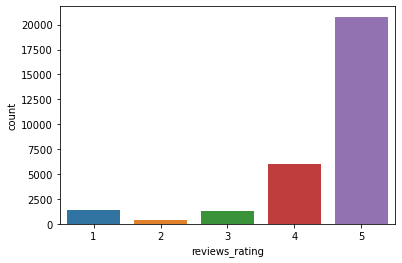

In [14]:
sns.countplot(df['reviews_rating'])
plt.show()

In [15]:
df['reviews_didPurchase'].value_counts().sort_values(ascending=False)

False    14497
True      1434
Name: reviews_didPurchase, dtype: int64

We see that only 1434 people have actually purchased products present in our data.

In [16]:
df['reviews_didPurchase'].isnull().sum()

14005

In [17]:


len(df['brand'].unique())



214

We have data of 214 brands

In [18]:


df['brand'].value_counts().sort_values(ascending=False)[:10]



Clorox                  10565
Warner Home Video        3325
Disney                   1199
L'oreal Paris            1186
FOX                       887
Burt's Bees               881
Sony Pictures             845
Summit Entertainment      813
Nexxus                    692
Universal Home Video      668
Name: brand, dtype: int64

In [19]:
df.groupby('brand')['reviews_rating'].agg(['mean','count']).sort_values(by='count',ascending=False)[:10]

,mean,count
brand,,
Clorox,4.824326,10565
Warner Home Video,4.350677,3325
Disney,4.687239,1199
L'oreal Paris,4.026981,1186
FOX,4.335964,887
Burt's Bees,4.650397,881
Sony Pictures,4.674556,845
Summit Entertainment,4.585486,813
Nexxus,1.354046,692


We see that Nexxus has lowest rating in the top 10 brands for which people have given most reviews

In [20]:
len(df['categories'].unique())

270

In [21]:
df['categories'].value_counts().sort_values(ascending=False)[:5]

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8525
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

Now that we have performed basic analysis on data, let us do text processing for the columns that we shall use for sentiment analysis.

# Text pre-procesing

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    #For removing punctuation
    text = str(text).translate(str.maketrans('', '', string.punctuation))
    #For removing number and special characters
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    text = re.sub(pattern, ' ', text)
    return text

In [23]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    text = clean_text(text)
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

First we will combine reviews title and text, to perform sentiment analysis on it. Hence, concatenating both columns

In [28]:
df.to_csv("df.csv")

In [29]:
df.reviews_title_text[df.reviews_title_text.isna()]

Series([], Name: reviews_title_text, dtype: object)

Since the data type in title text is string, hence changing the same.

In [30]:
#df.reviews_title_text = df.reviews_title_text.astype(str)

In [31]:
!pip install swifter
import swifter

df_clean = pd.DataFrame()
df_clean['reviews_title_text'] = df.reviews_title_text.swifter.apply(clean_text)

You should consider upgrading via the 'c:\users\pbabbar\anaconda3\python.exe -m pip install --upgrade pip' command.


Pandas Apply:   0%|          | 0/29747 [00:00<?, ?it/s]

For performing sentiment analysis, we will convert the sentiment into 0 and 1. 1 for positive and 0 for negative.

In [32]:
df['sentiment_binary'] = df.user_sentiment.replace({'Positive':1,'Negative':0})
df['sentiment_binary'].head()

0    1
1    1
2    1
3    0
4    0
Name: sentiment_binary, dtype: int64

### Feature Extraction

In [33]:
# Spliting into X & y
X = df_clean['reviews_title_text'].values
y = df.sentiment_binary

# Building a TF IDF matrix out of the corpus of reviews
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X).toarray()

In [34]:
df_clean.isna().sum()

reviews_title_text    0
dtype: int64

In [35]:
'''df['vectorized_reviews_title_text'] = X.tolist()
df_clean['vectorized_reviews_title_text'] = df['vectorized_reviews_title_text']'''

"df['vectorized_reviews_title_text'] = X.tolist()\ndf_clean['vectorized_reviews_title_text'] = df['vectorized_reviews_title_text']"

In [36]:
df_clean['name']=df['name']

We are saving this dataframe for uses in further notebooks

In [37]:
df_clean.to_csv("df_clean.csv")

In [38]:
# Splitting into training & test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42)

In [39]:
df['sentiment_binary'].value_counts(normalize=True)

1    0.887888
0    0.112112
Name: sentiment_binary, dtype: float64

### Text Classification - Model Buidling

#### Handling positive and negative imblance

In [40]:
#Since there is a data imbalance, we use technique called SMOTE to make data balanced.
from imblearn.over_sampling import SMOTE
from collections import Counter
#We only apply this technique on train data

counter = Counter(y_train)
print('Before',counter)

smt = SMOTE()

X_train_sm,y_train_sm = smt.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print('After ',counter)

Before Counter({1: 18468, 0: 2354})
After  Counter({1: 18468, 0: 18468})


#### First applying Logistic regression on data with smote and data without smote

In [41]:
# Logistic Regression
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred_logreg = clf.predict(X_test)

clf_sm = LogisticRegression(random_state=42,max_iter=1000).fit(X_train_sm, y_train_sm)
y_pred_logreg_sm = clf_sm.predict(X_test)


#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))
pickle.dump(clf_sm, open("logreg_model_sm.pkl", "wb"))

Let us create a dataframe to hold model evaluation scores.

- Since we are classifying the data, for us the best scores will be preceision and recall , not accuracy to check our model performance. He we shall go with the same.

In [42]:
df_sentiment_scores = pd.DataFrame(columns=['Method','Precision_normal','Recall_Normal','Precision_SMOTE','Recall_SMOTE'])

In [43]:
from sklearn.metrics import precision_score,recall_score,confusion_matrix
dict_temp =  {'Method':'LogReg','Precision_normal':precision_score(y_test, y_pred_logreg),'Recall_Normal':recall_score(y_test, y_pred_logreg),'Precision_SMOTE':precision_score(y_test, y_pred_logreg_sm),'Recall_SMOTE':recall_score(y_test, y_pred_logreg_sm)}
df_sentiment_scores = df_sentiment_scores.append(dict_temp,ignore_index=True)
df_sentiment_scores
  

,Method,Precision_normal,Recall_Normal,Precision_SMOTE,Recall_SMOTE
0,LogReg,0.909363,0.995217,0.958523,0.901813


In [44]:
'''from sklearn.model_selection import GridSearchCV
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]} 
clf_sm_gs = GridSearchCV(clf_sm, param_grid=grid_values).fit(X_train_sm, y_train_sm)'''

"from sklearn.model_selection import GridSearchCV\ngrid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]} \nclf_sm_gs = GridSearchCV(clf_sm, param_grid=grid_values).fit(X_train_sm, y_train_sm)"

#### Applying Random Forest with and without smote data

In [45]:
from sklearn.ensemble import RandomForestClassifier
clf_rm = RandomForestClassifier(max_depth=10, random_state=42)
clf_rm.fit(X_train, y_train)
clf_rm_sm = RandomForestClassifier(max_depth=10,random_state=42).fit(X_train_sm, y_train_sm)
#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

pickle.dump(clf_sm, open("RF_model_sm.pkl", "wb"))

In [46]:
y_pred_rm = clf_rm.predict(X_test)
y_pred_rm_sm = clf_rm_sm.predict(X_test)
dict_temp =  {'Method':'RandomForest','Precision_normal':precision_score(y_test, y_pred_rm),'Recall_Normal':recall_score(y_test, y_pred_rm),'Precision_SMOTE':precision_score(y_test, y_pred_rm_sm),'Recall_SMOTE':recall_score(y_test, y_pred_rm_sm)}
df_sentiment_scores = df_sentiment_scores.append(dict_temp,ignore_index=True)
df_sentiment_scores

,Method,Precision_normal,Recall_Normal,Precision_SMOTE,Recall_SMOTE
0,LogReg,0.909363,0.995217,0.958523,0.901813
1,RandomForest,0.890084,1.000000,0.923913,0.855992


#### Applying XGBoost classifier with and without smote data

In [47]:
from xgboost import XGBClassifier
clf_xg = XGBClassifier(random_state=42).fit(X_train, y_train)
clf_xg_sm = XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)
y_pred_xg = clf_xg.predict(X_test)
y_pred_xg_sm = clf_xg_sm.predict(X_test)
pickle.dump(clf, open("XG_model.pkl", "wb"))
pickle.dump(clf_sm, open("XG_model_sm.pkl", "wb"))

C:\Users\pbabbar\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
dict_temp =  {'Method':'XGBoost','Precision_normal':precision_score(y_test, y_pred_xg),'Recall_Normal':recall_score(y_test, y_pred_xg),'Precision_SMOTE':precision_score(y_test, y_pred_xg_sm),'Recall_SMOTE':recall_score(y_test, y_pred_xg_sm)}
df_sentiment_scores = df_sentiment_scores.append(dict_temp,ignore_index=True)
df_sentiment_scores

,Method,Precision_normal,Recall_Normal,Precision_SMOTE,Recall_SMOTE
0,LogReg,0.909363,0.995217,0.958523,0.901813
1,RandomForest,0.890084,1.000000,0.923913,0.855992
2,XGBoost,0.918995,0.989678,0.948099,0.919814


 - XG Boost without smote is performing the best, hence we shall use it in the final recommendation step.
 

In [49]:
df_sentiment_scores.to_csv("df_sentiment_scores.csv")

In [50]:
df.sentiment_binary.value_counts()

1    26412
0     3335
Name: sentiment_binary, dtype: int64

#### Recommendation Model

#### In this notebook we will run collaborative filtering methods, namely item item and user user, and determine the best among both and use that for final recommendation

In [51]:
import pandas as pd
import re,string
import numpy as np

- We had removed the null values of important columns and saved it as df.csv, hence we are importing the same

In [52]:
df = pd.read_csv("df.csv")
df.head()

,Unnamed: 0,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_title_text
0,0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive,Just Awesomei love this album. it's very good....
1,1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive,GoodGood flavor. This review was collected as ...
2,2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive,GoodGood flavor.
3,3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,DisappointedI read through the reviews on here...
4,4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,IrritationMy husband bought this gel for us. T...


- We see that there are no null username in this df

In [53]:
df[df.reviews_username.isna()]

,Unnamed: 0,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_title_text


In [54]:
df_for_recommendation = df


- Since there are duplicates for 'reviews_username' and 'name', hence we shall remove it. I found there are duplictated because pivot table could not be created previously.

In [55]:
df_for_recommendation = df_for_recommendation.drop_duplicates(subset=['reviews_username','name'],keep='first')

- Splitting data between train and test

In [56]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_for_recommendation, test_size=0.30, random_state=42)

- Creating pivot to understand relation between reviews_username and product name

In [57]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating').fillna(0)
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset


In [58]:

dummy_train = train.copy()
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>0 else 1)

In [59]:
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [60]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [61]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Using adjusted cosine similarity

In [62]:

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [63]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
from sklearn.metrics.pairwise import pairwise_distances

In [65]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Predicting user-user based similarity.

- Ignoring correlation <0 since it means users are not interested in it

In [66]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
user_predicted_ratings.shape

(17732, 237)

- Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [69]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Finding top 20 products

In [70]:
user_input = input("Enter your user name")
print(user_input)

Enter your user namejoshua
joshua


In [71]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:19]

In [72]:
d

name
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                3.933900
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                          2.665009
Bounce Dryer Sheets, Fresh Linen, 160 sheets                                       2.665009
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    2.139524
The Resident Evil Collection 5 Discs (blu-Ray)                                     1.688657
Mike Dave Need Wedding Dates (dvd + Digital)                                       1.506424
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                              1.458207
Alex Cross (dvdvideo)                                                              1.028319
Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish             0.842750
Hormel Chili, No Beans                                                             0.842750
Jason Aldean - They Don't Know                                             

#### Evaltuation for User-User based similarity

In [73]:

common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1040, 15)

In [74]:
common.head()

,Unnamed: 0,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews_title_text
20800,20984,Tostitos,"Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...",Tostitos,Tostitos Bite Size Tortilla Chips,False,True,5,Awesome,Yum,NaN,NaN,momof3,Positive,YumAwesome
2594,2619,Universal Home Video,"Movies, Music & Books,Movies,Comedy,Movies & T...",Universal,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,NaN,False,3,The first was definitely better than this sequ...,Definitely Second to the First,NaN,NaN,jbasa,Positive,Definitely Second to the FirstThe first was de...
11442,11540,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,False,True,5,Love the smell of this one and Clorox is strea...,streak free shine!!,NaN,NaN,mshoe,Positive,streak free shine!!Love the smell of this one ...
9025,9119,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,NaN,True,5,We donated these to our daughters classroom an...,Works Great At Killing Germs,Murrieta,NaN,gtguru497,Positive,Works Great At Killing GermsWe donated these t...
4363,4412,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover,Hoover174 Platinum Collection153 Lightweight B...,NaN,NaN,5,Suction is superb. Brings the nap up in the ca...,Best vacuum I have ever owned,NaN,NaN,donnap,Positive,Best vacuum I have ever ownedSuction is superb...


In [75]:
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [76]:
user_correlation_df = pd.DataFrame(user_correlation)

In [77]:
df_subtracted.head(1)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17722,17723,17724,17725,17726,17727,17728,17729,17730,17731
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [80]:
user_correlation_df_1.shape




(859, 17732)

In [81]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

user_correlation_df_3 = user_correlation_df_2.T

user_correlation_df_3.head()



,00sab00,1234,1witch,37f5p,abby,acjuarez08,actionaction,adam,adelynsmom,aimee,...,wolverine,woottos,wvshopaholic,xavier,xmom,yeyo,yohnie1,yummy,zach,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
user_correlation_df_3.shape

user_correlation_df_3[user_correlation_df_3<0]=0



In [83]:
common_user_based_matrix

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bisquick Original Pancake And Baking Mix - 40oz,...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yeyo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yohnie1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings




array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>0 else 0)

dummy_test = dummy_test.pivot_table( index='reviews_username',
    columns='name',
    values='reviews_rating').fillna(0)

print(dummy_test.shape)

common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

(859, 112)


In [86]:
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bisquick Original Pancake And Baking Mix - 40oz,...,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Calculating the RMSE for only the Products rated by user.

In [87]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\pbabbar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\pbabbar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [88]:
common_ = common.pivot_table( index='reviews_username',
    columns='name',
    values='reviews_rating')

In [89]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [90]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(round(rmse,2))

2.52


RMSE for user user is 2.52

### Item based similarity

In [91]:
df_pivot = train.pivot(
   index='name',
    columns='reviews_username',
    values='reviews_rating'
)

df_pivot.head()

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,1234,1234561,...,zowie,zozo0o,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,1234,1234561,...,zowie,zozo0o,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [94]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [95]:
#### Predition Item Item

In [96]:

item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings
item_predicted_ratings.shape
dummy_train.shape



(17732, 237)

#### Filetering products not rated by user

In [97]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.029419,0.0,0.0,0.0,0.0,0.0,0.0,0.013051,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006823,0.017098,0.0
02dakota,0.0,0.007697,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018516,0.006355,0.0
02deuce,0.0,0.006158,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014813,0.005084,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


#### Finding top 20 recommendations

In [98]:
user_input = input("Enter your user name")
print(user_input)

Enter your user namejoshua
joshua


In [99]:
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:19]
d

name
Chester's Cheese Flavored Puffcorn Snacks                                                                  0.166022
Nexxus Exxtra Gel Style Creation Sculptor                                                                  0.060284
Tostitos Bite Size Tortilla Chips                                                                          0.056611
Cococare 100% Natural Castor Oil                                                                           0.045543
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                                                            0.043133
Meguiar's Deep Crystal Car Wash 64-Oz.                                                                     0.042322
Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz                                           0.041015
Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz                                         0.039541
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)               

#### Evaluation - Item Item based recommendation

In [100]:
test.columns

common =  test[test.name.isin(train.name)]
common.shape

common.head(4)

common_item_based_matrix = common.pivot_table(index='name', columns='reviews_username', values='reviews_rating')

common_item_based_matrix.shape

item_correlation_df = pd.DataFrame(item_correlation)

item_correlation_df.head(1)

item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:

list_name = common.name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

In [102]:
item_correlation_df_3 = item_correlation_df_2.T



In [103]:
item_correlation_df_3.head()

item_correlation_df_3[item_correlation_df_3<0]=0



In [104]:
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.00749298, 0.00461828, ..., 0.        , 0.01367573,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01661788, 0.00073382, 0.01110969, ..., 0.0030172 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00381293, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [105]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>0 else 0)

dummy_test = dummy_test.pivot_table(index='name', columns='reviews_username', values='reviews_rating').fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [106]:
common_ = common.pivot_table(index='name', columns='reviews_username', values='reviews_rating')

In [107]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\pbabbar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\pbabbar\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [108]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [109]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5740059611894166


- RMSE is used to evaluate which model is better. If RMSE is less, that means the model is performing better.
- Since rmse of user user based model is less, hence we will go with the same.
- Therefore we will save the result in a csv file for it.

In [110]:
user_final_rating.to_csv("user_final_rating.csv")

#### Fine-Tuning Model

In [111]:
import pandas as pd

- We saved the product recommendation results in user_final_rating, we shall use that

In [112]:
user_final_rating = pd.read_csv("user_final_rating.csv",index_col='reviews_username')

In [113]:
user_input = input("Enter your user name")
print(user_input)

Enter your user namejoshua
joshua


- We saved the df after cleaning and contatenating reviews title and text in df_clean , hence we shall use that

In [114]:
df_clean = pd.read_csv("df_clean.csv",index_col='Unnamed: 0')

df_clean

,reviews_title_text,name
0,just awesomei love this album its very good mo...,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,goodgood flavor this review was collected as p...,Lundberg Organic Cinnamon Toast Rice Cakes
2,goodgood flavor,Lundberg Organic Cinnamon Toast Rice Cakes
3,disappointedi read through the reviews on here...,K-Y Love Sensuality Pleasure Gel
4,irritationmy husband bought this gel for us th...,K-Y Love Sensuality Pleasure Gel
...,...,...
29995,softnessi got this conditioner with influenste...,L'or233al Paris Elvive Extraordinary Clay Reba...
29996,i love iti love it i received this for review...,L'or233al Paris Elvive Extraordinary Clay Reba...
29997,hair is so smooth after usefirst of all i love...,L'or233al Paris Elvive Extraordinary Clay Reba...
29998,perfect for my oily hairi received this throug...,L'or233al Paris Elvive Extraordinary Clay Reba...


Loading the log reg model and preparing X for prediction

In [115]:
#Loading the XG boost model
import pickle
clf = pickle.load(open("XG_model_sm.pkl","rb"))
#Creating X and predicting y
X = df_clean['reviews_title_text'].values
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X).toarray()
y =  clf.predict(X)
#Creating a column for predicted sentiment ie y
df_clean['predicted_sentiment'] = y

In [116]:
df_clean['predicted_sentiment'].value_counts()

1    24999
0     4748
Name: predicted_sentiment, dtype: int64

- Since now we have the sentiment analysis results, we will store it in df_predicted and export it for easy use when we deploy our app

In [117]:
df_predicted = df_clean
df_predicted.to_csv("df_predicted_xg.csv")

Creating a function to get top 5 recommended products

In [118]:
def get_top_5_sentiment_reommendation(user_input):
  d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
  dict_scores={}
  for a in d.index:
    #print(a,d[a])
    #Normalized Score for sentiment positive
    pos_score = df_clean[df_clean['name']==a].predicted_sentiment.value_counts(normalize=True)[1]
    rec_score = d[a]
    #Multiplying both
    final_score = pos_score*rec_score
   # print(a)
    dict_scores[a]=final_score
  b = sorted(dict_scores, key=dict_scores.get, reverse=True)[:5]
 # print(b)
  return b

In [119]:
get_top_5_sentiment_reommendation('joshua')

['Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Bounce Dryer Sheets, Fresh Linen, 160 sheets',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'The Resident Evil Collection 5 Discs (blu-Ray)']

- We will use above function and df_predicted for our deployed app